In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from datetime import datetime as dt
from dateutil.parser import parse
import re

In [2]:
# we only want the interval data from a single agency
# other ones for NM:  32000-2, 32000-3, 32000-901, 32000-4, 32000-61, 32000-8, 32000-9, 32000-18
agency = "2002-100"
# read the file in chunks, then append only the data that matches that agency
print(dt.now())
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])
print(dt.now())

2019-01-28 11:57:15.651827
2019-01-28 11:57:32.168879


In [3]:
# add a new column which is the timestamp as a datetime object
df['ts'] = df.apply(lambda row: parse(row.timestamp), axis=1)

In [4]:
# add a new column for the hour of the day
df['HR'] = df.apply(lambda row: row.ts.hour, axis=1)

In [5]:
# add a new column for the day of the week
df['DOW'] = df.apply(lambda row: row.ts.weekday(), axis=1)

In [6]:
# this function will return a 'code' for Weekend, Night, or Day
def timeslot(h,d):
    # h - hour of day
    # d - day of week (0=Monday)
    if d > 4:             # day 5 or 6 (saturday or sunday)
        return "W"        # then Weekend
    elif h < 8 or h > 17: # before 7:59a or after 5:59p 
        return "N"        # then Night
    else:                 # otherwise
        return "D"        # Day

In [7]:
# make a new column with the timeslot code in it
df['SLOT'] = df.apply(lambda row: timeslot(row.HR, row.DOW), axis=1)

In [8]:
print("{} records for agency: {}".format(len(df), agency))
print("first 5:")
df.head()

331 records for agency: 2002-100
first 5:


,Unnamed: 0,interval,origindex,timestamp,uniquename,ts,HR,DOW,SLOT
1576737,1576737,43292.0,28271.0,2018-09-13 12:45:41,2002-100,2018-09-13 12:45:41,12,3,D
1576738,1576738,14365.0,41968.0,2018-09-13 16:45:06,2002-100,2018-09-13 16:45:06,16,3,D
1576739,1576739,17949.0,55898.0,2018-09-13 21:44:15,2002-100,2018-09-13 21:44:15,21,3,N
1576740,1576740,10853.0,62560.0,2018-09-14 00:45:08,2002-100,2018-09-14 00:45:08,0,4,N
1576741,1576741,43211.0,89604.0,2018-09-14 12:45:19,2002-100,2018-09-14 12:45:19,12,4,D


In [9]:
# this removes the rows considered to be 'outliers'
trimmed = df[df.interval < 100000]

In [10]:
print("some basic stats:")
trimmed["interval"].describe().apply(lambda x: format(x, '.2f'))

some basic stats:


count      329.00
mean     21203.88
std      13958.27
min          7.00
25%      14243.00
50%      14397.00
75%      23673.00
max      75796.00
Name: interval, dtype: object

In [11]:
# the series of interest
series_of_interest = trimmed["interval"]
# # of bins
bins_to_use = 100

In [12]:
# use the stats module to do the same histogram calculations as sns.distplot
# using the same bucketing parameters
bin_maxes, bin_edges, binnumber = stats.binned_statistic(series_of_interest, series_of_interest, statistic=max, bins=bins_to_use)

/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


<IPython.core.display.Javascript object>


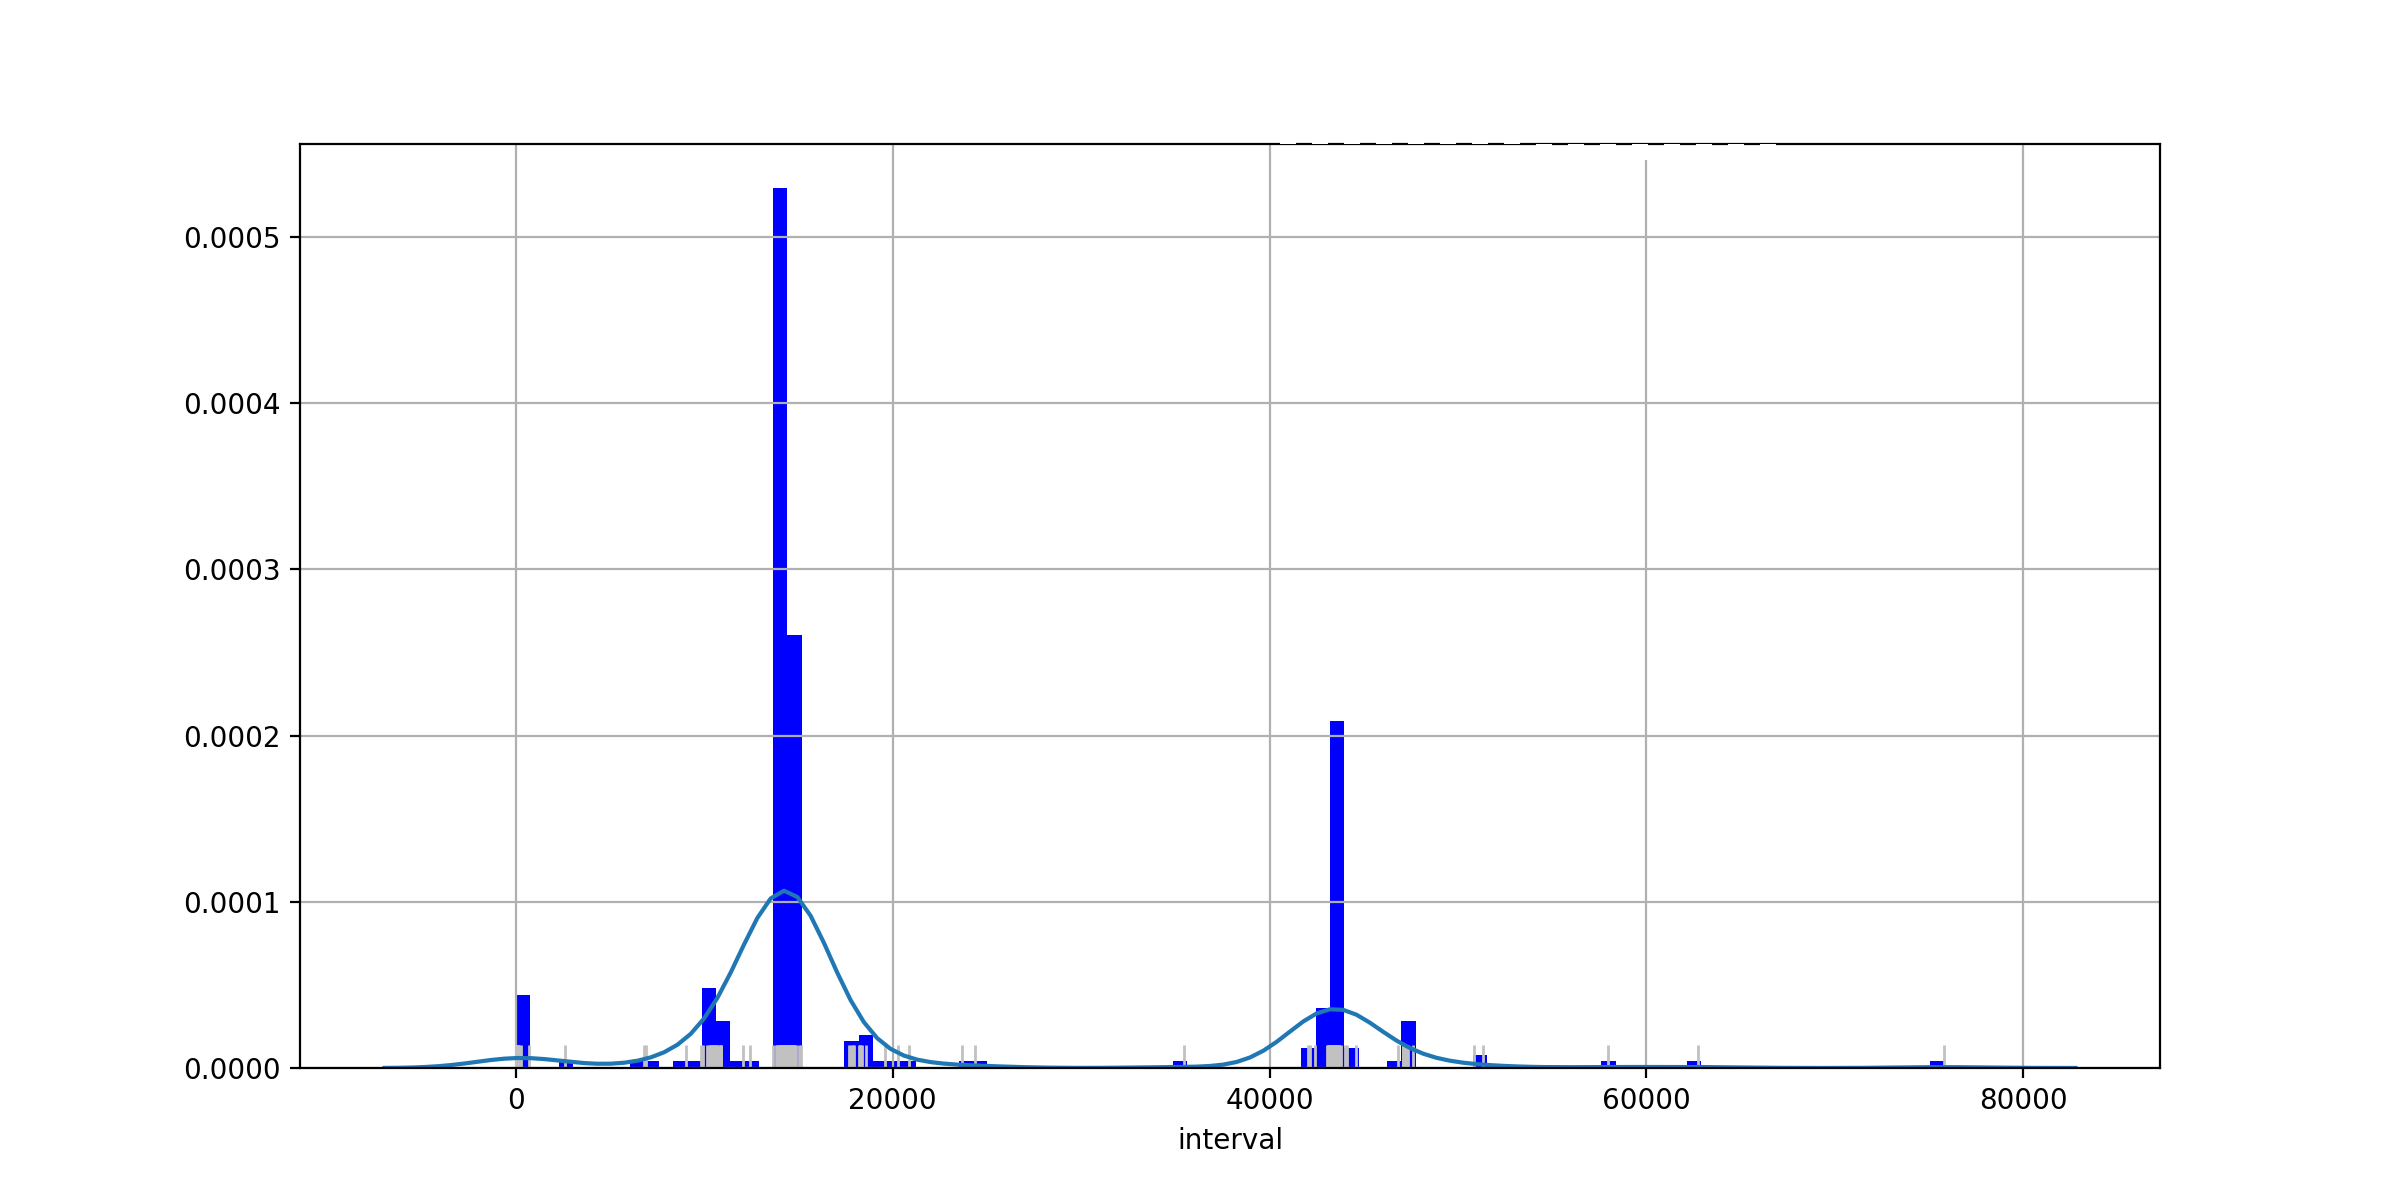

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [13]:
# graph the distribution of intervals using the .distplot function
# the .patches objects represent each graphed bin
# sns.set_style('ticks')
fig = plt.figure()
ax = plt.subplot()
ax.grid(True, which='both')  # set a grid
# ax.spines['left'].set_position((system, poisition))

fig.set_size_inches(12, 6)
rugkws={"height": .025, "color": "999999"}
histkws={"linewidth": 2, "alpha": 1, "color": "b"}
p = sns.distplot(series_of_interest, bins=bins_to_use, rug=True, rug_kws=rugkws, hist_kws=histkws, kde=True).patches

annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(bar):
    x = bar.get_x()+bar.get_width()/2.
    y = bar.get_y()+bar.get_height()
    annot.xy = (x,y)
    text = "{:.0f}@{:.0f} secs".format( y,x )
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for bar in p:
            cont, ind = bar.contains(event)
            if cont:
                update_annot(bar)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show();

In [ ]:
# get the heights of the bins
heights = [item.get_height() for item in p]
# the highest
print("the highest bar is {}".format(max(heights)))
# sort the list, biggest first
sorted_heights = sorted(heights, reverse=True)
# top X
x = 5
print("info for top {}:".format(x))
for i in range(0,x):
    thebin = heights.index(sorted_heights[i])
    print("# {} - height: {}, bin: {}, max interval in bin: {}, right-edge of bin: {}".format(i+1,sorted_heights[i], thebin, bin_maxes[thebin], bin_edges[thebin+1]))
    